In [1]:
import numpy as np
from matplotlib import pyplot as plt
import shelve
from pymc3_hpd import *
from scipy import stats
from scipy.linalg import lstsq

/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
bk_restore = shelve.open('mcmc_unlabel_sim2_v1.pkl')
# bk_restore = shelve.open('mcmc_unlabel_sim2_v_tmp.pkl')
for k in bk_restore:
    try:
        globals()[k]=bk_restore[k]
        tmp[k] = bk_restore[k]
    except:
        pass
bk_restore.close()

In [3]:
iter_use_start = int(n_iter/4)

# 1. Histograms of # of clusters

In [4]:
def intHist(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

## 1A. nCluster of neuron

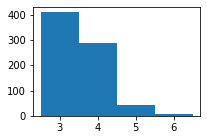

In [18]:
plt.rcParams['figure.figsize'] = [3, 2]
# plt.hist(t_fit[iter_use_start:])
intHist(t_fit[iter_use_start:])
plt.savefig("hist_nNeuron.svg")

## 1B. nCluster of states

In [7]:
n_states_fit = np.zeros((n_iter,), dtype = int)
for kk in range(n_iter):
    n_states_fit[kk] = np.unique(dynamics_fit[kk]['states']).size

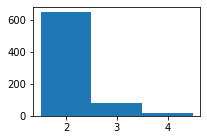

In [19]:
plt.rcParams['figure.figsize'] = [3, 2]

intHist(n_states_fit[iter_use_start:])
plt.savefig("hist_nStates.svg")

# 2. Similarity matrix

## 2A. neuron

In [9]:
simMat_neuron = np.zeros((N,N))
count = 0
for g in range(iter_use_start, n_iter):
    count = count + 1
    for k in range(simMat_neuron.shape[0]):
        simMat_neuron[k,:] = simMat_neuron[k,:] + (Z_fit[g,k] == Z_fit[g,:])
simMat_neuron = simMat_neuron/count

simMat_neuron_true = np.zeros((N,N))
for k in range(simMat_neuron_true.shape[0]):
    simMat_neuron_true[k,:] = (lab_neuron[k] == lab_neuron)

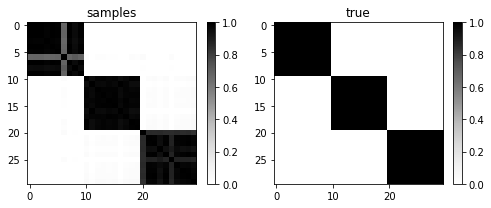

In [20]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)
z1 = ax[0].imshow(simMat_neuron, aspect="auto", cmap = 'Greys')
ax[0].set_title('samples')
plt.colorbar(z1, ax= ax[0])
z2 = ax[1].imshow(simMat_neuron_true, aspect="auto", cmap = 'Greys')
ax[1].set_title('true')
plt.colorbar(z2, ax= ax[1])
fig.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("simMat_neuron.svg")

## 2B. states

In [11]:
simMat_state = np.zeros((T,T))
count = 0
for g in range(iter_use_start, n_iter):
    count = count + 1
    for k in range(simMat_state.shape[0]):
        simMat_state[k,:] = simMat_state[k,:] + (dynamics_fit[g]['states'][k] == dynamics_fit[g]['states'])
simMat_state = simMat_state/count

simMat_state_true = np.zeros((T,T))
for k in range(simMat_state_true.shape[0]):
    simMat_state_true[k,:] = (lab_t[k] == lab_t)
sim_order = np.append(np.where(lab_t == 0)[0], np.where(lab_t == 1)[0])

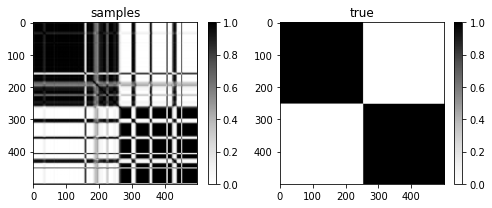

In [21]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)
z1 = ax[0].imshow(simMat_state[np.ix_(sim_order, sim_order)], aspect="auto", cmap = 'Greys')
ax[0].set_title('samples')
plt.colorbar(z1, ax= ax[0])
z2 = ax[1].imshow(simMat_state_true[np.ix_(sim_order, sim_order)], aspect="auto", cmap = 'Greys')
ax[1].set_title('true')
plt.colorbar(z2, ax= ax[1])
fig.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("simMat_states.svg")

# 3. maxPEAR of states
Here, I need to use the R package...
First, output the samples for state to csv

In [16]:
states_samp = np.zeros((n_iter, T))
for mm in range(n_iter):
    states_samp[mm,:] = dynamics_fit[mm]['states']
states_samp_use = states_samp[iter_use_start:,:]
np.savetxt("states_samp.csv", states_samp_use, delimiter=",")
# then use R package

In [17]:
states_samp_maxPEAR = np.loadtxt("states_samp_maxPEAR.csv", delimiter=",", dtype = int) - 1

# align to truth
np.unique(states_samp_maxPEAR) # 2
swap = {0: 1, 1:0}
states_samp_maxPEAR_swap = np.array([swap[x] for x in states_samp_maxPEAR])

sum((states_samp_maxPEAR - lab_t)**2)
sum((states_samp_maxPEAR_swap - lab_t)**2)

441

## 3A. maxPEAR of the states

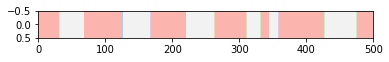

In [459]:
plt.rcParams['figure.figsize'] = [6, .5]
plt.imshow(states_samp_maxPEAR[None,:], aspect="auto", cmap='Pastel1')
plt.xlim([0, T])
plt.savefig("states_maxPEAR.svg")

## 3B. true states

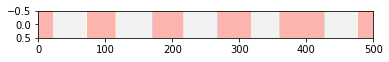

In [460]:
plt.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')
plt.xlim([0, T])
plt.savefig("states_true.svg")

# 4. latent trajectoreis

In [160]:
# a = np.random.normal(size = (100,3))
# hpd(a, alpha=0.025)

In [22]:
unique_lab = np.sort(np.unique(lab_neuron))
neuron_set = {}
for zz in unique_lab:
    neuron_set[zz] = np.where(lab_neuron == zz)[0]

z_clus_plot = np.ones((unique_lab.size, n_iter), dtype = int)*-99
mu_clus_plot = np.zeros((n_iter,unique_lab.size,T))
X_clus_plot = []
for _ in unique_lab:
    X_clus_plot.append(np.zeros((n_iter, p, T)))

for idx, zz in enumerate(unique_lab):
    obsIdx = (lab_neuron==zz)
    z_clus_plot[idx,:] = stats.mode(Z_fit[:,obsIdx].T)[0][0]
    
    for kk in range(n_iter):
        mu_clus_plot[kk,idx,:] = muX_fit[kk][z_clus_plot[idx,kk]][0,:]
        X_clus_plot[idx][kk,:,:] = muX_fit[kk][z_clus_plot[idx,kk]][1:,:]
        

In [23]:
muMean_plot = np.zeros((unique_lab.size, T))
muLB_plot = np.zeros((unique_lab.size, T))
muUB_plot = np.zeros((unique_lab.size, T))

for ii in range(unique_lab.size):
    mu_samp = mu_clus_plot[iter_use_start:,ii,:]
    hdp_tmp = hpd(mu_samp, alpha=0.025)
    
    muMean_plot[ii,:] = np.mean(mu_samp,0)
    muLB_plot[ii,:] = hdp_tmp[:,0]
    muUB_plot[ii,:] = hdp_tmp[:,1]

    
XMean_plot = []
XLB_plot = []
XUB_plot = []
for ii in range(unique_lab.size):
    X_samp_tmp = X_clus_plot[ii][iter_use_start:,:,:]
    for kk in range(X_samp_tmp.shape[0]):
        rot_tmp = lstsq(X_samp_tmp[kk,:,:].T,muX_all[ii][1:,].T)[0].T
        X_samp_tmp[kk,:,:] = rot_tmp @ X_samp_tmp[kk,:,:]
    
    XMean_tmp = np.zeros((p,T))
    XLB_tmp = np.zeros((p,T))
    XUB_tmp = np.zeros((p,T))
    for jj in range(p):
        X_samp_sub = X_samp_tmp[:,jj,:]
        Xhdp_tmp = hpd(X_samp_sub, alpha=0.025)
        
        XMean_tmp[jj,:] = np.mean(X_samp_sub,0)
        XLB_tmp[jj,:] = Xhdp_tmp[:,0]
        XUB_tmp[jj,:] = Xhdp_tmp[:,1]
    
    XMean_plot.append(XMean_tmp)
    XLB_plot.append(XLB_tmp)
    XUB_plot.append(XUB_tmp)

## 4A. mu

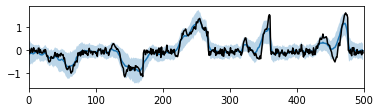

In [24]:
plt.rcParams['figure.figsize'] = [6, 1.5]

ii=0
plt.plot(muMean_plot[ii,:])
plt.fill_between(np.arange(0,T), muUB_plot[ii,:], muLB_plot[ii,:], alpha=0.3)
plt.plot(muX_all[ii][0,:], 'k')
plt.xlim([0, T])
plt.savefig("mu.svg")

## 4B. X

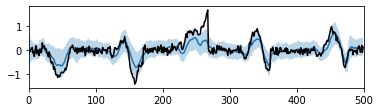

In [25]:
jj = 0

plt.plot(XMean_plot[ii][jj,:])
plt.fill_between(np.arange(0,T), XLB_plot[ii][jj,:], XUB_plot[ii][jj,:], alpha=0.3)
plt.plot(muX_all[ii][jj+1,], 'k')
plt.xlim([0, T])
plt.savefig("x1.svg")

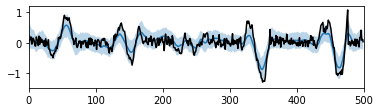

In [26]:
jj = 1

plt.plot(XMean_plot[ii][jj,:])
plt.fill_between(np.arange(0,T), XLB_plot[ii][jj,:], XUB_plot[ii][jj,:], alpha=0.3)
plt.plot(muX_all[ii][jj+1,], 'k')
plt.xlim([0, T])
plt.savefig("x2.svg")